This notebook was pulled from the Kaggle "Predict Future Sales" competition: (https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost)

Slight changes were made within the hyperparameters of the model, and test metrics. ChatGPT-5 was used for the additions into this model code. Specific implementation can be seen commented throughout this notebook.

This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline:
* Load data
* Heal data and remove outliers
* Work with shops/items/cats objects and features
* Create matrix as product of item/shop pairs within each month in the train set
* Get monthly sales for each item/shop pair in the train set and merge it to the matrix
* Clip item_cnt_month by (0,20)
* Append test to the matrix, fill 34 month nans with zeros
* Merge shops/items/cats to the matrix
* Add target lag features
* Add mean encoded features
* Add price trend features
* Add month
* Add days
* Add months since last sale/months since first sale features
* Cut first year and drop columns which can not be calculated for the test set
* Select best features
* Set validation strategy 34 test, 33 validation, less than 33 train
* Fit the model, predict and clip targets for the test set

# Part 1: Cleaning the Data

### Imports + Data

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

#-- Reading in the data
items = pd.read_csv('/content/items.csv')
shops = pd.read_csv('/content/shops.csv')
cats = pd.read_csv('/content/item_categories.csv')
train = pd.read_csv('/content/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('/content/test-2.csv').set_index('ID')

### Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

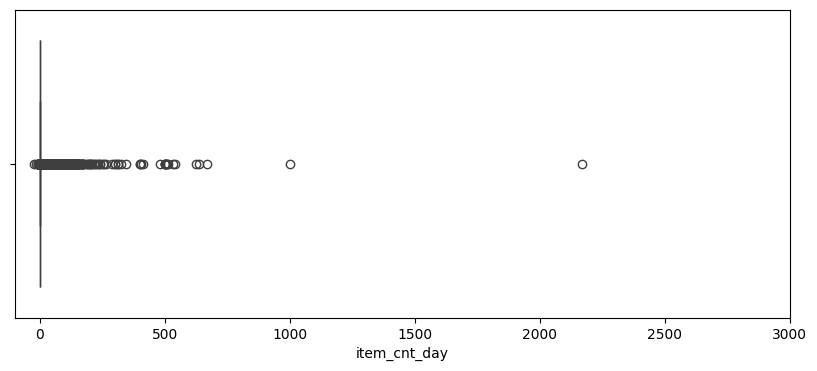

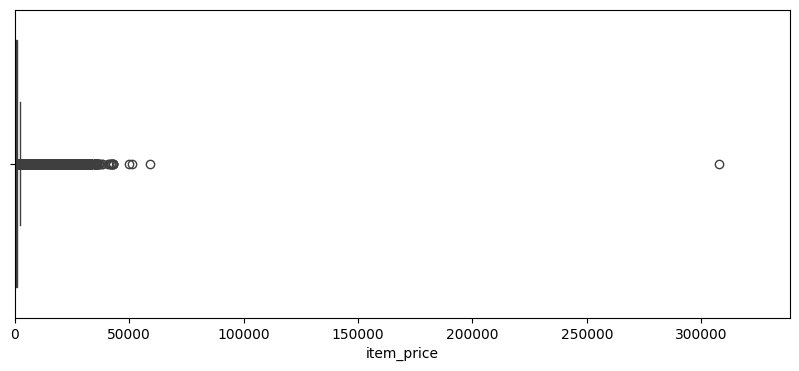

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)
plt.show()

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)
plt.show()


In [ ]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [ ]:
#-- There is one item with price below zero so it was filled with median.
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

#-- Several shops are duplicates of each other (according to its name). Fix train and test set.

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
print(train['item_cnt_day'].describe())
print(train['item_cnt_day'].value_counts().head(20))
print(train['item_cnt_day'].quantile([0.9, 0.95, 0.99, 0.999, 0.9999]))


count    2.935847e+06
mean     1.241903e+00
std      2.292963e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+03
Name: item_cnt_day, dtype: float64
item_cnt_day
 1.0     2629371
 2.0      194201
 3.0       47350
 4.0       19685
 5.0       10474
-1.0        7252
 6.0        6338
 7.0        4057
 8.0        2903
 9.0        2177
 10.0       1820
 11.0       1263
 12.0       1083
 13.0        918
 14.0        716
 15.0        638
 16.0        544
 17.0        438
 18.0        391
 20.0        364
Name: count, dtype: int64
0.9000     2.0
0.9500     2.0
0.9900     5.0
0.9990    22.0
0.9999    67.0
Name: item_cnt_day, dtype: float64


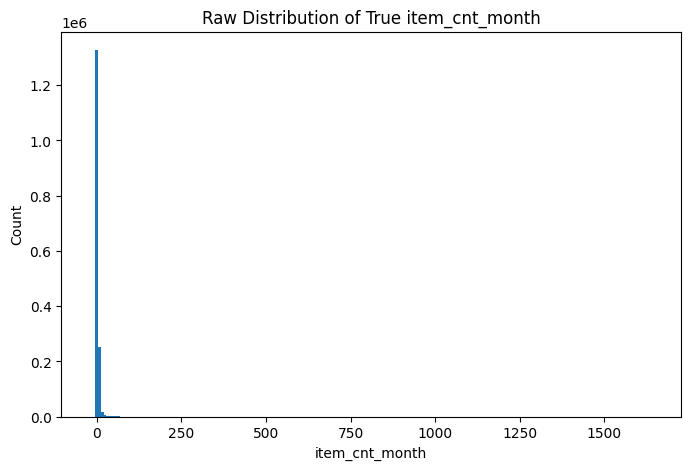

In [ ]:
monthly = train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index()
monthly.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

plt.figure(figsize=(8,5))
plt.hist(monthly['item_cnt_month'], bins=200)
plt.title("Raw Distribution of True item_cnt_month")
plt.xlabel("item_cnt_month")
plt.ylabel("Count")
plt.show()

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [ ]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero.
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [ ]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [ ]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

9.915343284606934

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>Using float16 prevents pandas from upcasting the column to int64 when test rows w NaN values are added</i>

In [ ]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [ ]:
ts = time.time()
group = (
    train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day']
         .sum()
         .reset_index()
         .rename(columns={'item_cnt_day': 'item_cnt_month'})
)
matrix = matrix.merge(group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # keep target in (0,20) similar to the test predicttions
                                .astype(np.float16))
time.time() - ts

7.261345148086548

## Test set
To use time tricks append test pairs to the matrix.

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [ ]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

/tmp/ipython-input-1884388999.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)


0.1298229694366455

## Shops/Items/Cats features

In [ ]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.389672756195068

## Target lags

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

42.07907819747925

## Mean encoded features

In [ ]:
# mean encoding of date_block_num-level mean
# creates date_avg_item_cnt assgined to lag

group = (
    matrix.groupby(['date_block_num'])['item_cnt_month']
          .mean()
          .reset_index(name='date_avg_item_cnt')
)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
# mean encoding of date x item mean

group = (
    matrix.groupby(['date_block_num', 'item_id'])['item_cnt_month']
          .mean()
          .reset_index(name='date_item_avg_item_cnt')
)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#mean encoding of date_block_num x shop_id

group = (
    matrix.groupby(['date_block_num', 'shop_id'])['item_cnt_month']
          .mean()
          .reset_index(name='date_shop_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
#mean encoding of date_block_num x item_category_id
group = (
    matrix.groupby(['date_block_num', 'item_category_id'])['item_cnt_month']
          .mean()
          .reset_index(name='date_cat_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
# mean encoding of date x shop_id x item
group = (
    matrix.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month']
          .mean()
          .reset_index(name='date_shop_cat_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# tsmean encoding of date x shop x type code
group = (
    matrix.groupby(['date_block_num', 'shop_id', 'type_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_shop_type_avg_item_cnt')
)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#mean encoding of date x shop x sub type code
group = (
    matrix.groupby(['date_block_num', 'shop_id', 'subtype_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_shop_subtype_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# #mean encoding of date x city code
group = (
    matrix.groupby(['date_block_num', 'city_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_city_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
# #mean encoding of date x city code x item id

group = (
    matrix.groupby(['date_block_num', 'item_id', 'city_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_item_city_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
#mean encoding of date x type
group = (
    matrix.groupby(['date_block_num', 'type_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_type_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)


In [ ]:
#mean encoding of date x subtype

group = (
    matrix.groupby(['date_block_num', 'subtype_code'])['item_cnt_month']
          .mean()
          .reset_index(name='date_subtype_avg_item_cnt')
)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)


## Trend features

Price trend for the last six months.

In [ ]:
ts = time.time()

#mean price per item
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# mean price per item per month
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

#price lags
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

/tmp/ipython-input-25617662.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matrix['delta_price_lag'].fillna(0, inplace=True)


161.64811730384827

Last month shop revenue trend

In [ ]:
#monthly revenue per shop
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

#mean revenue per shop for all months
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)


#relative revenue trend
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)


#lag revenue trend
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

175.0987992286682

## Special features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
time.time() - ts

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, XGBoost

In [ ]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [ ]:
data.describe()

## Train/test/split

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
Y_test = data[data.date_block_num == 34]['item_cnt_month']

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
del data
gc.collect();

## Model

ChatGPT-5 was used in tuning the hyperparameters for this model.

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=10,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.05,
    seed=42,
    eval_metric="rmse", early_stopping_rounds=10
)

model.fit(
    X_train,
    Y_train,
    eval_set=[(X_valid, Y_valid)],
    verbose=True
)

print("Training time:", time.time() - ts)


# Error Metrics

## RMSE/ MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

Y_pred = model.predict(X_valid).clip(0, 20)

mse = mean_squared_error(Y_valid, Y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(Y_valid, Y_pred)
r2   = r2_score(Y_valid, Y_pred)


print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

ChatGPT Prompt used: Cell 63 & 61 were provided with the following: "Give me the train, validation and test RMSE and MAE from this model."

In [ ]:
import numpy as np

# ---- TRAIN RMSE ----
train_preds = model.predict(X_train)
train_rmse = np.sqrt(np.mean((Y_train - train_preds) ** 2))

# ---- VALIDATION RMSE ----
valid_preds = model.predict(X_valid)
valid_rmse = np.sqrt(np.mean((Y_valid - valid_preds) ** 2))

# ---- TEST RMSE ----
test_preds = model.predict(X_test)
test_rmse = np.sqrt(np.mean((Y_test - test_preds) ** 2))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val   RMSE: {valid_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")


In [ ]:
# ---- TRAIN MAE ----
train_mae = np.mean(np.abs(Y_train.values - model.predict(X_train)))

# ---- VALIDATION MAE ----
valid_mae = np.mean(np.abs(Y_valid.values - model.predict(X_valid)))

# ---- TEST MAE ----
test_preds = model.predict(X_test).clip(0, 20)
test_mae = np.mean(np.abs(Y_test.values - test_preds))

print(f"Train MAE: {train_mae:.4f}")
print(f"Val   MAE: {valid_mae:.4f}")
print(f"Test  MAE: {test_mae:.4f}")

## Segmented Error Analysis

Cell 60-63 were provided with the following prompt: "Run segmented error analysis using the given data features and the model provided."

#### Train / Validation / Test predictions + RMSE & MAE

In [ ]:
# ---- PREDICTIONS ----
train_preds = model.predict(X_train).clip(0, 20)
valid_preds = model.predict(X_valid).clip(0, 20)
test_preds  = model.predict(X_test).clip(0, 20)

# ---- MANUAL ERRORS ----
train_errors = Y_train.values - train_preds
valid_errors = Y_valid.values - valid_preds
test_errors  = Y_test.values  - test_preds

# ---- RMSE & MAE FUNCTIONS ----
def rmse(e):
    return np.sqrt(np.mean(e**2))

def mae(e):
    return np.mean(np.abs(e))

#### Build dataframe for segmentation analysis

In [ ]:
#-- Dataframe
df_test = X_test.copy()
df_test['y_true'] = Y_test.values
df_test['y_pred'] = test_preds
df_test['err']    = test_errors
df_test['abs_err'] = np.abs(test_errors)
df_test['sq_err']  = test_errors**2

#-- Clean up the dataframe
df_test['delta_price_lag'] = df_test['delta_price_lag'].astype('float32')
df_test['y_true'] = df_test['y_true'].astype('float32')

#-- Error by SHOP ID
shop_errors = df_test.groupby('shop_id').agg(
    RMSE=('sq_err', lambda x: np.sqrt(np.mean(x))),
    MAE=('abs_err', 'mean'),
    Count=('y_true', 'count')
).sort_values("RMSE")

print("\n=== ERROR BY SHOP ID ===")
print(shop_errors.head(10))
print(shop_errors.tail(10))

#-- Error by ITEM CATEGORY
item_errors = df_test.groupby('item_id').agg(
    RMSE=('sq_err', lambda x: np.sqrt(np.mean(x))),
    MAE=('abs_err', 'mean'),
    Count=('y_true', 'count')
).sort_values("RMSE")

print("\n=== ERROR BY ITEM ID ===")
print(item_errors.head(10))
print(item_errors.tail(10))

cat_errors = df_test.groupby('item_category_id').agg(
    RMSE=('sq_err', lambda x: np.sqrt(np.mean(x))),
    MAE=('abs_err', 'mean'),
    Count=('y_true', 'count')
).sort_values("RMSE")

print("\n=== ERROR BY ITEM CATEGORY ===")
print(cat_errors)


#-- Error by PRICE LEVEL
df_test['price_bucket'] = pd.cut(
    df_test['delta_price_lag'],    # best proxy for price movement
    bins=[-10, -1, 0, 1, 3, 10],
    labels=['big_drop', 'drop', 'same', 'up', 'big_up']
)

price_errors = df_test.groupby('price_bucket').agg(
    RMSE=('sq_err', lambda x: np.sqrt(np.mean(x))),
    MAE=('abs_err', 'mean'),
    Count=('y_true', 'count')
)

print("\n=== ERROR BY PRICE BUCKET ===")
print(price_errors)

#-- Error by TARGET BUCKET
df_test['target_bucket'] = pd.cut(
    df_test['y_true'],
    bins=[0, 0.5, 1.5, 5, 20],
    labels=['0', '1', '2–5', '5+']
)

bucket_errors = df_test.groupby('target_bucket').agg(
    RMSE=('sq_err', lambda x: np.sqrt(np.mean(x))),
    MAE=('abs_err', 'mean'),
    Count=('y_true', 'count')
)

print("\n=== ERROR BY TARGET BUCKET ===")
print(bucket_errors)

bias_by_shop = df_test.groupby('shop_id').apply(
    lambda x: np.mean(x['y_pred'] - x['y_true'])
).sort_values()

print("\n=== BIAS BY SHOP (neg = underpredict) ===")
print(bias_by_shop)


Prompt used: "Create plots using the segmented error analysis for interpretation."

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=shop_errors.index, y=shop_errors['RMSE'])
plt.xticks(rotation=90)
plt.title("RMSE by Shop ID")
plt.ylabel("RMSE")
plt.xlabel("Shop ID")
plt.show()

plt.figure(figsize=(14,6))
sns.barplot(x=cat_errors.index, y=cat_errors['RMSE'])
plt.xticks(rotation=90)
plt.title("RMSE by Item Category")
plt.ylabel("RMSE")
plt.xlabel("Item Category ID")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=item_errors['Count'], y=item_errors['RMSE'])
plt.title("Item RMSE vs. Number of Observations")
plt.xlabel("Count in Test Set")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=price_errors.index.astype(str), y=price_errors['RMSE'])
plt.title("RMSE by Price Movement Bucket")
plt.ylabel("RMSE")
plt.xlabel("Price Bucket")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x=bias_by_shop.index, y=bias_by_shop.values)
plt.xticks(rotation=90)
plt.title("Prediction Bias by Shop ID")
plt.ylabel("Bias (Pred - Actual)")
plt.xlabel("Shop ID")
plt.axhline(0, color='black', linewidth=1)
plt.show()


In [ ]:
pivot = df_test.pivot_table(
    index='shop_id',
    columns='item_category_id',
    values='sq_err',
    aggfunc=lambda x: np.sqrt(np.mean(x))
)

plt.figure(figsize=(20,10))
sns.heatmap(pivot, cmap="viridis")
plt.title("RMSE Heatmap: Shop vs Item Category")
plt.show()

## Residual Analysis

ChatGPT-5 prompt used: Given the context of the above model, "Run me residual analysis on this model's performance"

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)

residuals = Y_valid - Y_pred

print("Mean residual:", residuals.mean())
print("Residual std:", residuals.std())

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(Y_pred, residuals, s=10)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (True - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()